# FakeNewsNetPreprocessing

This notebook preprocesses the FakeNewsNet dataset created by Shu et al. [7]. The dataset is hosted in a GitHub repository[8] and contains political and entertainment news along with social context and spatiotemporal data. The dataset includes the GossipCop and PolitiFact subsets, which will be explored, cleaned, processed, and saved to Google Drive for use in subsequent machine learning tasks in the Classifier notebook.



## Import necessary libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import re
from sklearn.utils import shuffle

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Download the datasets

In [2]:
# Downloading datasets from the GitHub repository
!wget "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv" -O gossipcop_fake.csv
!wget "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv" -O gossipcop_real.csv
!wget "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_fake.csv" -O politifact_fake.csv
!wget "https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/politifact_real.csv" -O politifact_real.csv

--2024-07-14 07:18:28--  https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_fake.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12538704 (12M) [text/plain]
Saving to: ‘gossipcop_fake.csv’

gossipcop_fake.csv  100%[===================>]  11.96M  79.1MB/s    in 0.2s    

2024-07-14 07:18:28 (79.1 MB/s) - ‘gossipcop_fake.csv’ saved [12538704/12538704]

--2024-07-14 07:18:28--  https://raw.githubusercontent.com/KaiDMML/FakeNewsNet/master/dataset/gossipcop_real.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 O

## Load the Data

In [3]:
# Load the datasets
gossipcop_fake = pd.read_csv('gossipcop_fake.csv')
gossipcop_real = pd.read_csv('gossipcop_real.csv')
politifact_fake = pd.read_csv('politifact_fake.csv')
politifact_real = pd.read_csv('politifact_real.csv')

# Quick check of the data loaded
print(gossipcop_fake.head())
print(gossipcop_real.head())
print(politifact_fake.head())
print(politifact_real.head())

                     id                                           news_url  \
0  gossipcop-2493749932  www.dailymail.co.uk/tvshowbiz/article-5874213/...   
1  gossipcop-4580247171  hollywoodlife.com/2018/05/05/paris-jackson-car...   
2   gossipcop-941805037  variety.com/2017/biz/news/tax-march-donald-tru...   
3  gossipcop-2547891536  www.dailymail.co.uk/femail/article-3499192/Do-...   
4  gossipcop-5476631226  variety.com/2018/film/news/list-2018-oscar-nom...   

                                               title  \
0  Did Miley Cyrus and Liam Hemsworth secretly ge...   
1  Paris Jackson & Cara Delevingne Enjoy Night Ou...   
2  Celebrities Join Tax March in Protest of Donal...   
3  Cindy Crawford's daughter Kaia Gerber wears a ...   
4      Full List of 2018 Oscar Nominations – Variety   

                                           tweet_ids  
0  284329075902926848\t284332744559968256\t284335...  
1  992895508267130880\t992897935418503169\t992899...  
2  853359353532829696\t853359

## Data Inspection

In [4]:
# Display basic information about each dataset
gossipcop_fake.info()
gossipcop_real.info()
politifact_fake.info()
politifact_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5323 entries, 0 to 5322
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5323 non-null   object
 1   news_url   5067 non-null   object
 2   title      5323 non-null   object
 3   tweet_ids  5135 non-null   object
dtypes: object(4)
memory usage: 166.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16817 entries, 0 to 16816
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         16817 non-null  object
 1   news_url   16804 non-null  object
 2   title      16817 non-null  object
 3   tweet_ids  15759 non-null  object
dtypes: object(4)
memory usage: 525.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         432 non-null    object
 1   news_url

## Initial Exploratory Data Analysis (EDA)

### Visualization of Class Distribution

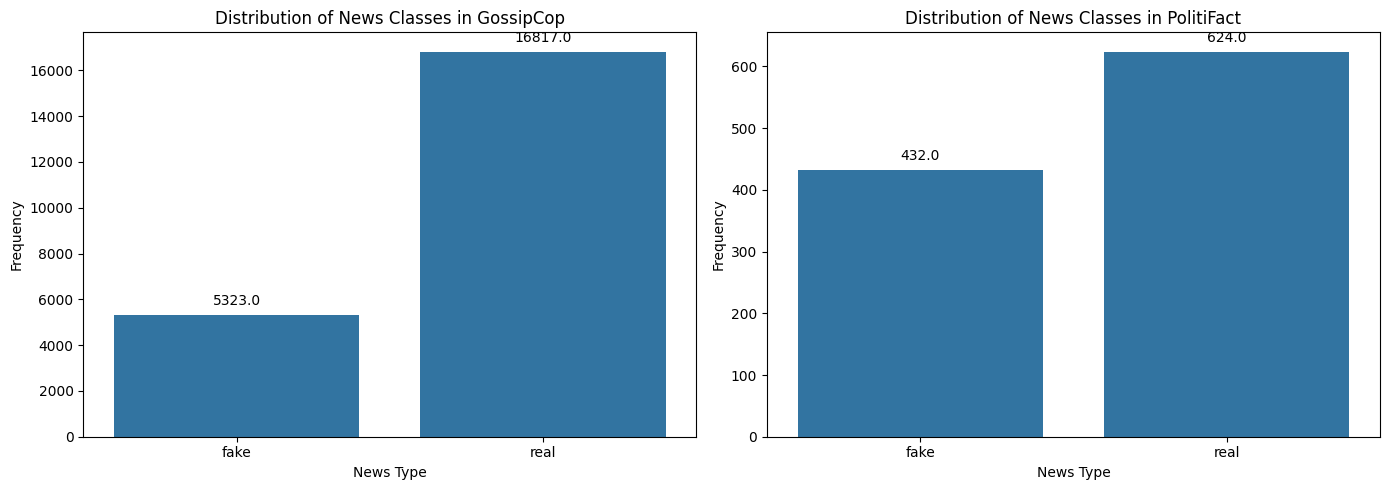

In [5]:
# Label the data
gossipcop_fake['label'] = 'fake'
gossipcop_real['label'] = 'real'
politifact_fake['label'] = 'fake'
politifact_real['label'] = 'real'

# Add dataset identifier
gossipcop_fake['dataset'] = 'GossipCop'
gossipcop_real['dataset'] = 'GossipCop'
politifact_fake['dataset'] = 'PolitiFact'
politifact_real['dataset'] = 'PolitiFact'

# Combine the datasets
combined = pd.concat([
    gossipcop_fake[['label', 'dataset']],
    gossipcop_real[['label', 'dataset']],
    politifact_fake[['label', 'dataset']],
    politifact_real[['label', 'dataset']]
])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for GossipCop
gossipcop_plot = sns.countplot(x='label', data=combined[combined['dataset'] == 'GossipCop'], ax=axes[0])
axes[0].set_title('Distribution of News Classes in GossipCop')
axes[0].set_xlabel('News Type')
axes[0].set_ylabel('Frequency')
# Annotate bars with count
for p in gossipcop_plot.patches:
    gossipcop_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Plot for PolitiFact
politifact_plot = sns.countplot(x='label', data=combined[combined['dataset'] == 'PolitiFact'], ax=axes[1])
axes[1].set_title('Distribution of News Classes in PolitiFact')
axes[1].set_xlabel('News Type')
axes[1].set_ylabel('Frequency')
# Annotate bars with count
for p in politifact_plot.patches:
    politifact_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

The datasets have class imbalance. There are approximately 3 times more records of real news than fake news in the GossipCop dataset. In the PolitiFact dataset, the number of fake news articles is about 30% less than that of real news articles. This will require a strategy to balance the dataset.

### Text Length Distribution

I will check text length distribution in title  column of both datasets and compare the real and fake news.

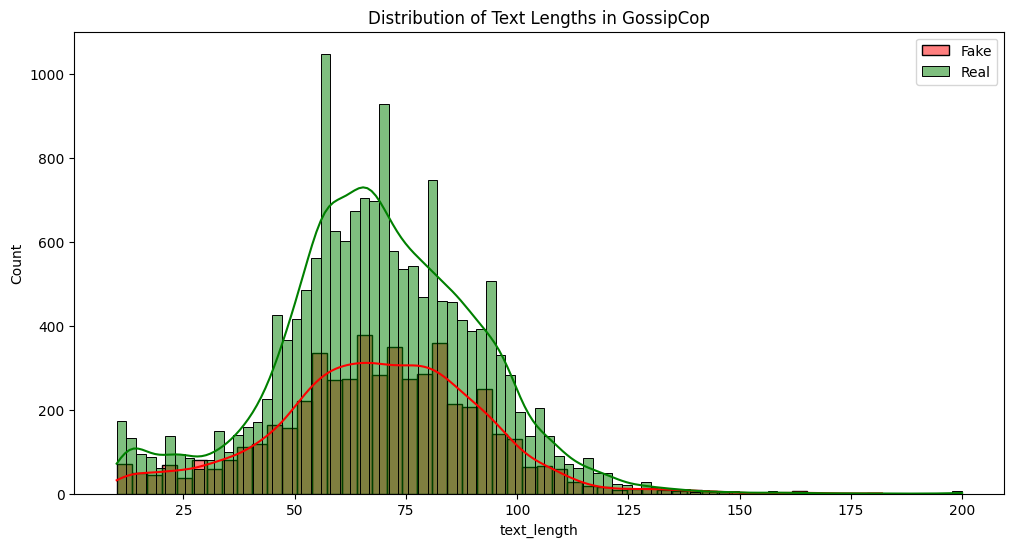

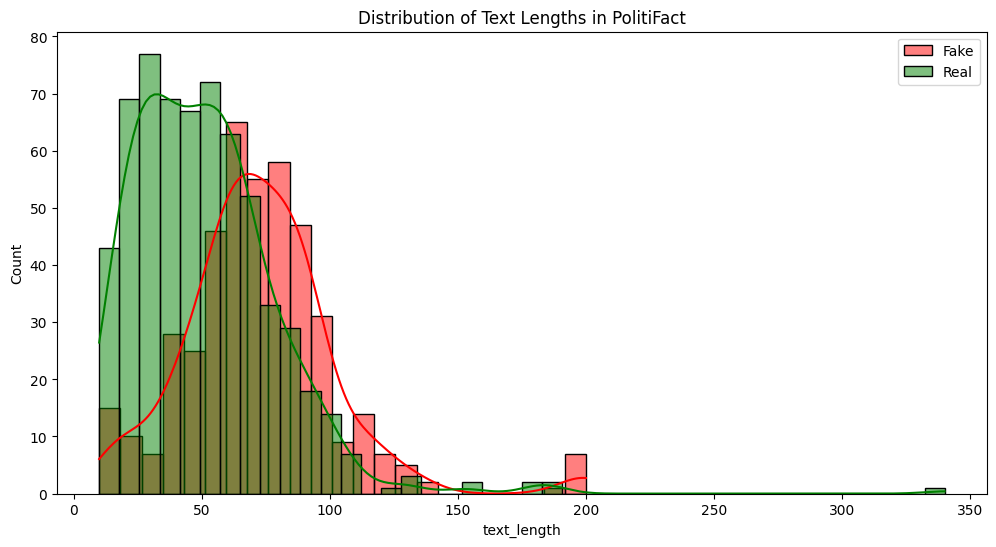

In [6]:
# Add text length as a new feature
gossipcop_fake['text_length'] = gossipcop_fake['title'].apply(len)
gossipcop_real['text_length'] = gossipcop_real['title'].apply(len)
politifact_fake['text_length'] = politifact_fake['title'].apply(len)
politifact_real['text_length'] = politifact_real['title'].apply(len)

# Visualize the distribution of text length
plt.figure(figsize=(12, 6))
sns.histplot(gossipcop_fake['text_length'], color='red', label='Fake', kde=True)
sns.histplot(gossipcop_real['text_length'], color='green', label='Real', kde=True)
plt.title('Distribution of Text Lengths in GossipCop')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(politifact_fake['text_length'], color='red', label='Fake', kde=True)
sns.histplot(politifact_real['text_length'], color='green', label='Real', kde=True)
plt.title('Distribution of Text Lengths in PolitiFact')
plt.legend()
plt.show()

The text length distributions indicate that real news generally has shorter titles compared to fake news in both GossipCop and PolitiFact datasets.

### Word Frequency Analysis

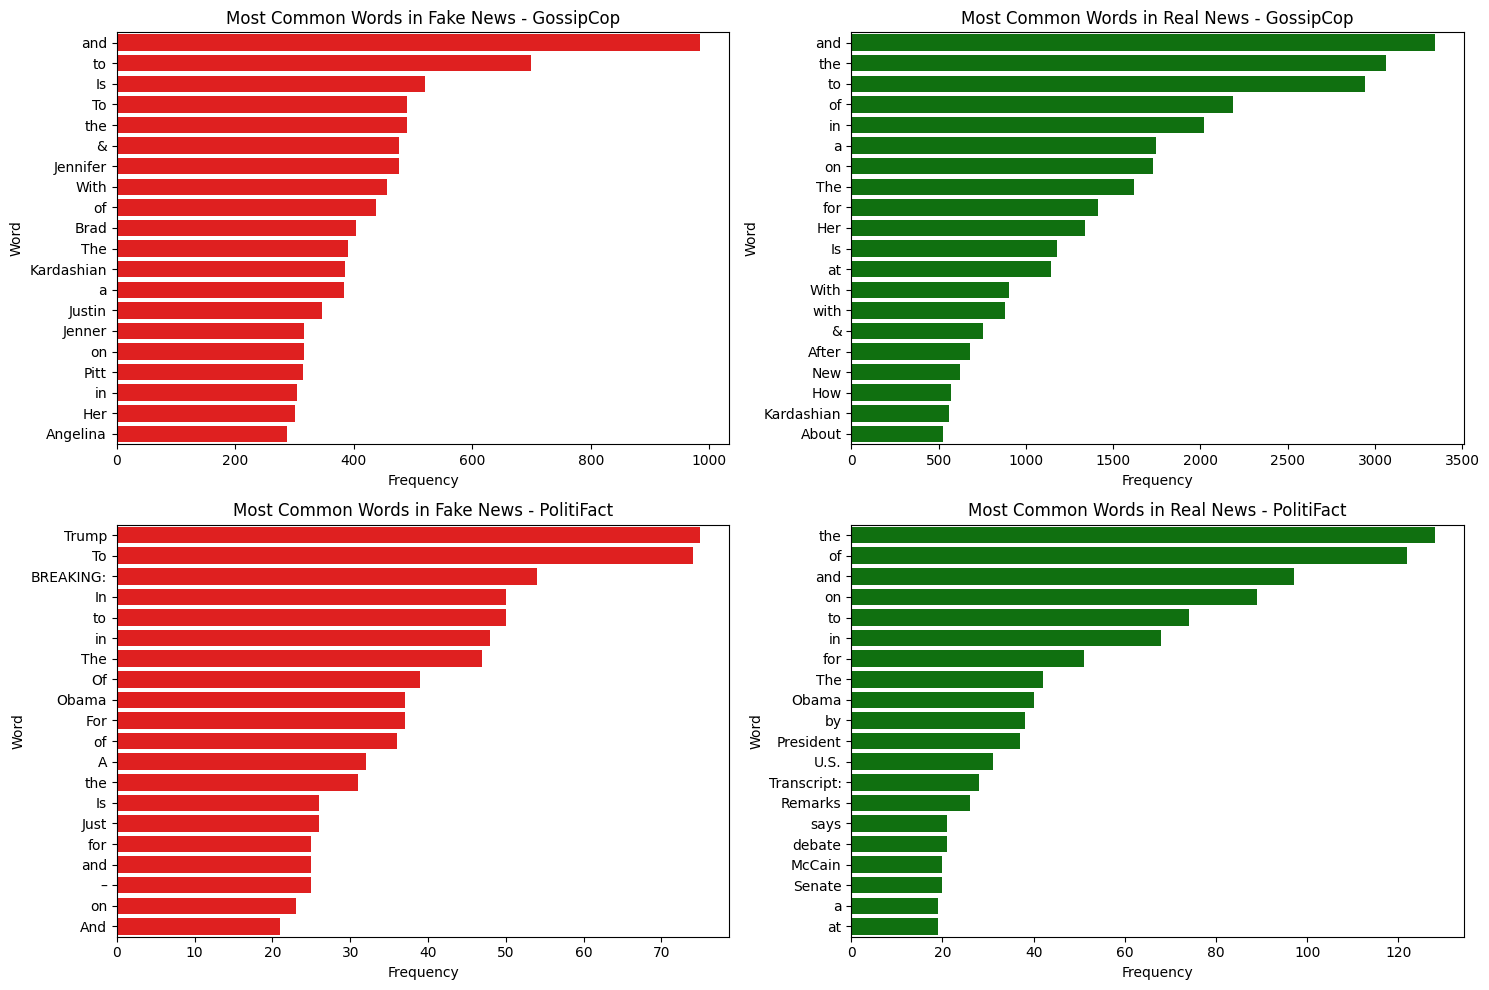

In [7]:
# Function to get the most common words
def get_most_common_words(text_list, num=20):
    all_words = ' '.join(text_list).split()
    common_words = Counter(all_words).most_common(num)
    return pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Apply the function to each dataset
fake_words_gossipcop = get_most_common_words(gossipcop_fake['title'])
real_words_gossipcop = get_most_common_words(gossipcop_real['title'])
fake_words_politifact = get_most_common_words(politifact_fake['title'])
real_words_politifact = get_most_common_words(politifact_real['title'])

# Plotting the results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.barplot(x='Frequency', y='Word', data=fake_words_gossipcop, ax=axes[0, 0], color='red')
axes[0, 0].set_title('Most Common Words in Fake News - GossipCop')

sns.barplot(x='Frequency', y='Word', data=real_words_gossipcop, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Most Common Words in Real News - GossipCop')

sns.barplot(x='Frequency', y='Word', data=fake_words_politifact, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Most Common Words in Fake News - PolitiFact')

sns.barplot(x='Frequency', y='Word', data=real_words_politifact, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Most Common Words in Real News - PolitiFact')

plt.tight_layout()
plt.show()

The most common words in fake news GossipCop are: and, to, Is.
The most common words in real news GossipCop are: and, the, to.
The most common words in fake news PolitiFact are: Trump, To, BREAKING:.
The most common words in real news PolitiFact are: the, of, and.
The results contain stopwords and punctuation and text in title column will need preprocessing.

## Data Cleaning

I will clean the data by removing unnecessary columns, which will prepare the datasets to include only relevant features (text column) for model training. Most machine learning algorithms require input data, including labels, to be numeric, so I will convert labels (label column) to numeric values. I will check for missing values in all columns of each dataset which will ensure the data's integrity. Cleaning step will ensure the compatibility with the machine learning algorithms that will be used in classifier notebook.

In [8]:
# Drop unneeded columns
columns_to_drop = ['id', 'news_url', 'tweet_ids', 'text_length', 'dataset']
gossipcop_fake.drop(columns=columns_to_drop, inplace=True)
gossipcop_real.drop(columns=columns_to_drop, inplace=True)
politifact_fake.drop(columns=columns_to_drop, inplace=True)
politifact_real.drop(columns=columns_to_drop, inplace=True)

# Convert labels to numeric values
label_mapping = {'fake': 0, 'real': 1}
gossipcop_fake['label'] = gossipcop_fake['label'].map(label_mapping)
gossipcop_real['label'] = gossipcop_real['label'].map(label_mapping)
politifact_fake['label'] = politifact_fake['label'].map(label_mapping)
politifact_real['label'] = politifact_real['label'].map(label_mapping)

# Check for missing values in all columns of each dataset
missing_values_gossipcop_fake = gossipcop_fake.isnull().sum()
missing_values_gossipcop_real = gossipcop_real.isnull().sum()
missing_values_politifact_fake = politifact_fake.isnull().sum()
missing_values_politifact_real = politifact_real.isnull().sum()

print("Missing values in GossipCop Fake:\n", missing_values_gossipcop_fake)
print("\nMissing values in GossipCop Real:\n", missing_values_gossipcop_real)
print("\nMissing values in PolitiFact Fake:\n", missing_values_politifact_fake)
print("\nMissing values in PolitiFact Real:\n", missing_values_politifact_real)

# check the datasets
print(gossipcop_fake.head())
print(gossipcop_real.head())
print(politifact_fake.head())
print(politifact_real.head())

Missing values in GossipCop Fake:
 title    0
label    0
dtype: int64

Missing values in GossipCop Real:
 title    0
label    0
dtype: int64

Missing values in PolitiFact Fake:
 title    0
label    0
dtype: int64

Missing values in PolitiFact Real:
 title    0
label    0
dtype: int64
                                               title  label
0  Did Miley Cyrus and Liam Hemsworth secretly ge...      0
1  Paris Jackson & Cara Delevingne Enjoy Night Ou...      0
2  Celebrities Join Tax March in Protest of Donal...      0
3  Cindy Crawford's daughter Kaia Gerber wears a ...      0
4      Full List of 2018 Oscar Nominations – Variety      0
                                               title  label
0  Teen Mom Star Jenelle Evans' Wedding Dress Is ...      1
1  Kylie Jenner refusing to discuss Tyga on Life ...      1
2                                      Quinn Perkins      1
3  I Tried Kim Kardashian's Butt Workout & Am For...      1
4  Celine Dion donates concert proceeds to Vegas ...   

## Feature Engineering

### Text Preprocessing

In [9]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and non-word characters
    text = re.sub(r'\W+', ' ', text)
    # Stemming and stopword removal
    words = text.split()
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply preprocessing to each title
gossipcop_fake['title'] = gossipcop_fake['title'].apply(preprocess_text)
gossipcop_real['title'] = gossipcop_real['title'].apply(preprocess_text)
politifact_fake['title'] = politifact_fake['title'].apply(preprocess_text)
politifact_real['title'] = politifact_real['title'].apply(preprocess_text)

### Visualize the Most Common Words After Preprocessing

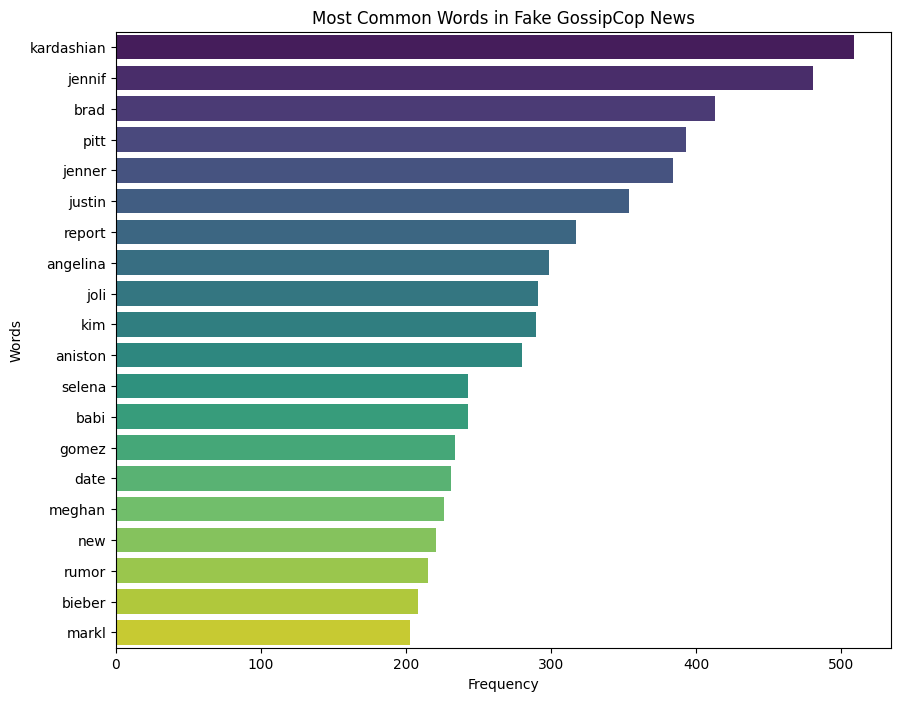

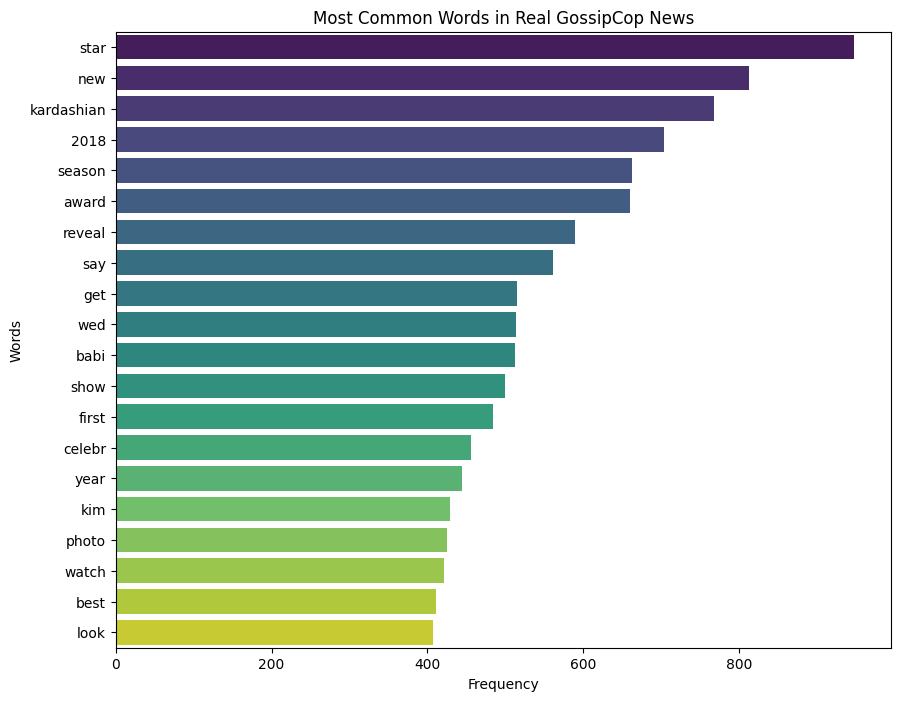

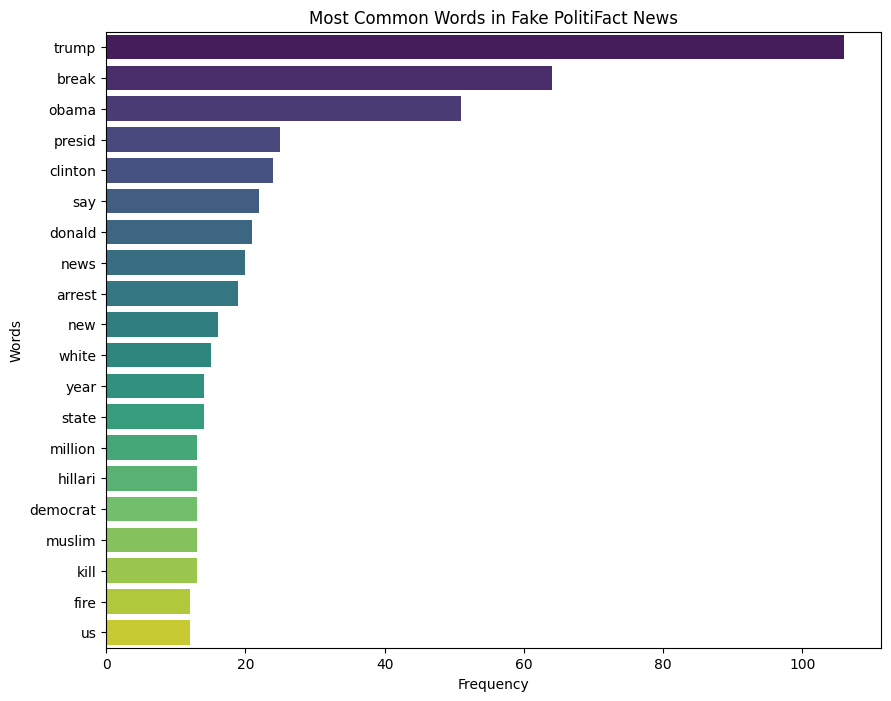

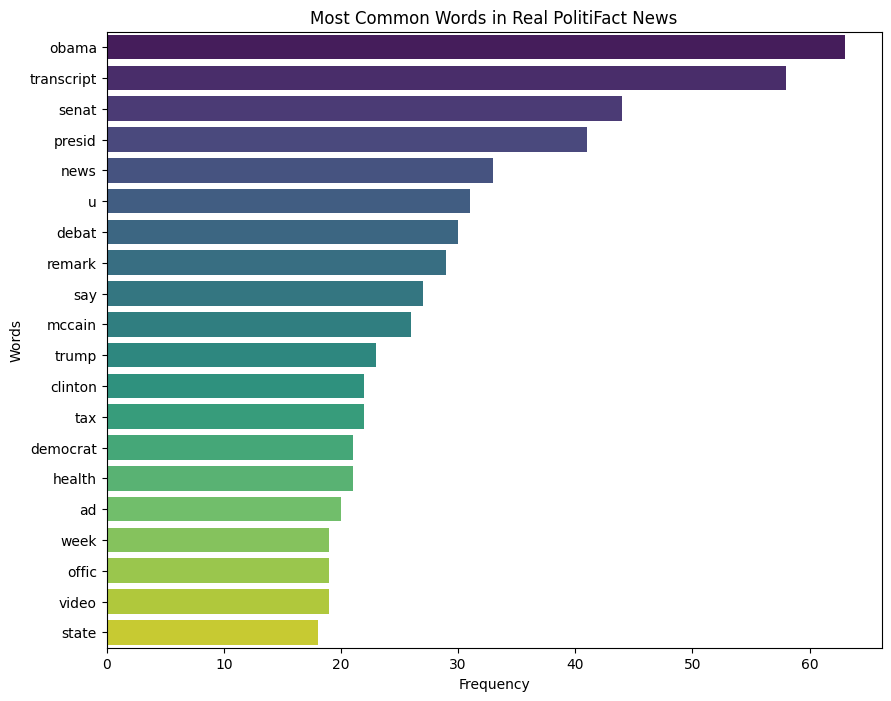

In [10]:
# Function to plot most common words
def plot_most_common_words(preprocessed_texts, title, num=20):
    all_words = ' '.join(preprocessed_texts).split()
    freq_dist = Counter(all_words)
    common_words = freq_dist.most_common(num)

    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]
    data = pd.DataFrame({'Word': words, 'Frequency': counts})

    plt.figure(figsize=(10, 8))
    sns.barplot(data=data, y='Word', x='Frequency', hue='Word', dodge=False, palette="viridis")
    plt.legend([],[], frameon=False) # Hides the legend as it's redundant in this context
    plt.title(f'Most Common Words in {title}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Apply the function to visualize data
plot_most_common_words(gossipcop_fake['title'], 'Fake GossipCop News')
plot_most_common_words(gossipcop_real['title'], 'Real GossipCop News')
plot_most_common_words(politifact_fake['title'], 'Fake PolitiFact News')
plot_most_common_words(politifact_real['title'], 'Real PolitiFact News')

The most common words in fake news GossipCop are: kardashian, jennif, brad.
The most common words in real news GossipCop are: star, new, kardashian.
The most common words in fake news PolitiFact are: trump, break, obama.
The most common words in real news PolitiFact are: obama, transcript, senat.

## Combine and Shuffle the Datasets

In [11]:
# Combine fake and real datasets for GossipCop and shuffle
gossipcop_combined = pd.concat([gossipcop_fake, gossipcop_real]).reset_index(drop=True)
gossipcop_combined = shuffle(gossipcop_combined, random_state=42)

# Combine fake and real datasets for PolitiFact and shuffle
politifact_combined = pd.concat([politifact_fake, politifact_real]).reset_index(drop=True)
politifact_combined = shuffle(politifact_combined, random_state=42)

# Check the combined datasets
print(gossipcop_combined.head())
print(politifact_combined.head())

                                                   title  label
11080  lea michel hairstylist mix textur spray coconu...      1
291    thoma markl princ harri polit miss daughter me...      0
17231  2019 sag award nomin see full list nomine varieti      1
16382  see meghan markl royal coat arm symbol hide wi...      1
9364     kyli jenner visit shaman life kyli season final      1
                                                  title  label
260          world popular candi remov shelv octob 2017      0
832                              brows congression bill      1
846                           suprem court vacanc video      1
1007                                    u import export      1
88    die 78 year old cia agent admit kill marilyn m...      0


## Save Preprocessed datasets to Google drive

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save preprocessed data to Google Drive
gossipcop_combined.to_csv('/content/drive/My Drive/gossipcop_preprocessed.csv', index=False)
politifact_combined.to_csv('/content/drive/My Drive/politifact_preprocessed.csv', index=False)

Mounted at /content/drive


## References

[7] SHU, K., MAHUDESWARAN, D., WANG, S., LEE, D., and LIU, H. 2018. FakeNewsNet: A Data Repository with News Content, Social Context and Dynamic Information for Studying Fake News on Social Media. https://doi.org/10.48550/arXiv.1809.01286

[8] SHU, K., MAHUDESWARAN, D., WANG, S., LEE, D., and LIU, H. 2018. FakeNewsNet: A Data Repository with News Content, Social Context, and Dynamic Information for Studying Fake News on Social Media. https://github.com/KaiDMML/FakeNewsNet

In [13]:
# Install LaTeX packages necessary for converting notebooks to PDF
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic texlive-latex-extra pandoc

# Convert the notebook to PDF
!jupyter nbconvert --to pdf "/content/drive/My Drive/Colab Notebooks/FakeNewsNetPreprocessing.ipynb"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,544 kB]
Get:14 http://security.ubuntu.co